# Code Interpreting with Gemini 1.5 Pro/Flash
This example uses the E2B's [Code Interpreter](https://github.com/e2b-dev/code-interpreter) as a tool for Gemini 1.5 pro/flash. We ask the LLM to show a chart which means the LLM will generate Python code that will get sent to E2B, we display the chart.

# Step 1: Install the dependencies


In [1]:
# Install the required packages
%pip install google-generativeai e2b_code_interpreter --upgrade


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Step 2: Define API keys, prompts and the tool

In [2]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your Google AI Studio API key. See here for more details: https://ai.google.dev/gemini-api/docs/api-key
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")

# TODO: Set your model name
MODEL_NAME = "gemini-1.5-flash-latest" # other options: "gemini-1.5-pro-latest"

# System prompt for the LLM
SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python_code` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python_code`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

Function calling is defined differently in Google's Generative AI SDK. Instead of defining the function schema in JSON, you can directly provide a Python function. The SDK will automatically convert the function into a format the API understands.

More details here: https://ai.google.dev/gemini-api/docs/function-calling/tutorial?lang=python#basics_of_function_calling

In [3]:
def execute_python_code(code: str):
    """
    Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error

    Args:
    - code: str: The python code to execute in a single cell.
    """
    print("Running code interpreter...")
    print(f"Code to execute: \n```\n{code}\n```")
    exec = code_interpreter.notebook.exec_cell(
        code,
        on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
        on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
        )
    if exec.error:
       print("[Code Interpreter ERROR]", exec.error)
    else:
      return exec.results

# Step 2: Initialise the LLM

In [4]:
import google.generativeai as genai

# Configure the API key
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the model, and pass the system instruction and tools
model = genai.GenerativeModel(model_name=MODEL_NAME, 
                              system_instruction=SYSTEM_PROMPT,
                              tools=[execute_python_code])

# Step 3: Run the LLM, extract the tool arguments, and execute the tool

Running code interpreter...
Code to execute: 
```

import matplotlib.pyplot as plt
import numpy as np

# Assuming a normal distribution with mean and standard deviation based on general population data
mean_height = 1.75  # meters
std_dev = 0.07  # meters

# Generate random heights based on the distribution
heights = np.random.normal(mean_height, std_dev, 1000)

# Create the histogram
plt.hist(heights, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Height (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Men\'s Heights')

# Show the plot
plt.show()

```


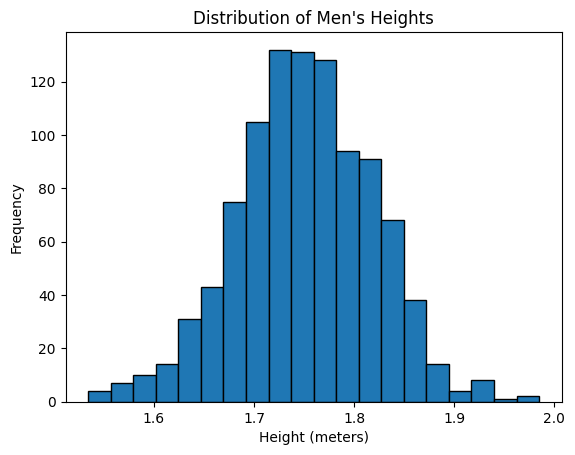

In [5]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
    # Send the prompt to the model
    response = model.generate_content("Visualize a distribution of height of men based on the latest data you know.")

    # Extract the arguments (i.e. `code`) from tool call
    # More details here: https://ai.google.dev/gemini-api/docs/function-calling/tutorial?lang=python#optional_low_level_access
    python_code = response.candidates[0].content.parts[0].function_call.args["code"]

    # Execute the code
    results = execute_python_code(python_code)

    if results:
        first_result = results[0]
    else:
        print("No code results")
        exit(0)

# Display the first result
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result